# Store Sales time-series Forecasting 

In [66]:
import glob
import os
import pandas as pd
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import locale
locale.setlocale(locale.LC_ALL, '')
pd.set_option('display.float_format', '{:,.3f}'.format)
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from ngboost import NGBRegressor

__loading data__

In [2]:
files = os.listdir('c:/data/store-sales-time-series-forecasting')
names = []
for i in files:
    names.append(i.split('.csv')[0])
names

['holidays_events',
 'oil',
 'sample_submission',
 'stores',
 'test',
 'train',
 'transactions']

In [3]:
g_list = glob.glob('c:/data/store-sales-time-series-forecasting/*')

In [4]:
df = {name : pd.read_csv(g_list[idx]) for idx, name in enumerate(names)}
df

{'holidays_events':            date        type    locale locale_name  \
 0    2012-03-02     Holiday     Local       Manta   
 1    2012-04-01     Holiday  Regional    Cotopaxi   
 2    2012-04-12     Holiday     Local      Cuenca   
 3    2012-04-14     Holiday     Local    Libertad   
 4    2012-04-21     Holiday     Local    Riobamba   
 ..          ...         ...       ...         ...   
 345  2017-12-22  Additional  National     Ecuador   
 346  2017-12-23  Additional  National     Ecuador   
 347  2017-12-24  Additional  National     Ecuador   
 348  2017-12-25     Holiday  National     Ecuador   
 349  2017-12-26  Additional  National     Ecuador   
 
                        description  transferred  
 0               Fundacion de Manta        False  
 1    Provincializacion de Cotopaxi        False  
 2              Fundacion de Cuenca        False  
 3        Cantonizacion de Libertad        False  
 4        Cantonizacion de Riobamba        False  
 ..                      

### train / test

In [29]:
df['train'].head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

__store_nbr__ identifies the store at which the products are sold.     
__family__ identifies the type of product sold.    
__sales__ gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).    
__onpromotion__ gives the total number of items in a product family that were being promoted at a store at a given date.

In [44]:
print('Numbers of null in train data :\n{}'.format(df['train'].isnull().sum()))
print('Numbers of null in test data :\n{}'.format(df['test'].isnull().sum()))

Numbers of null in train data :
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
Numbers of null in test data :
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


In [45]:
print('Numbers of unique values in train data :\n{}'.format(df['train'].nunique()))
print('Numbers of unique values in test data :\n{}'.format(df['test'].nunique()))

Numbers of unique values in train data :
id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64
Numbers of unique values in test data :
id             28512
date              16
store_nbr         54
family            33
onpromotion      212
dtype: int64


In [46]:
df['train'].store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [47]:
df['train'].family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [48]:
df['train'].onpromotion.unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13

In [49]:
df['train'].sales.unique()

array([0.000000e+00, 2.000000e+00, 8.100000e+02, ..., 4.381330e+02,
       1.545530e+02, 2.419729e+03])

### stores / oil / transactions

In [51]:
df['stores'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [53]:
df['stores'].head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [63]:
df['oil'].isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [139]:
df['transactions'].head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [140]:
df['transactions'].nunique()

date            1682
store_nbr         54
transactions    4993
dtype: int64

### holidays events

In [64]:
df['holidays_events'].head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [65]:
df['holidays_events'].nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

In [73]:
print('Type of type columns : \n{}'.format(list(df['holidays_events'].type.unique())))
print('Type of locale columns : \n{}'.format(list(df['holidays_events'].locale.unique())))
print('Type of locale_name columns : \n{}'.format(list(df['holidays_events'].locale_name.unique())))
print('Type of transferred  columns : \n{}'.format(list(df['holidays_events'].transferred .unique())))

Type of type columns : 
['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event']
Type of locale columns : 
['Local', 'Regional', 'National']
Type of locale_name columns : 
['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo', 'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato', 'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas', 'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil']
Type of transferred  columns : 
[False, True]


In [105]:
print('Numbers of type columns : \n{}'.format(df['holidays_events'].type.value_counts()))
print('\nNumbers of locale columns : \n{}'.format(df['holidays_events'].locale.value_counts()))
print('\nNumbers of locale_name columns : \n{}'.format(df['holidays_events'].locale_name.value_counts()))
print('\nNumbers of transferred  columns : \n{}'.format(df['holidays_events'].transferred.value_counts()))

Numbers of type columns : 
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

Numbers of locale columns : 
National    174
Local       152
Regional     24
Name: locale, dtype: int64

Numbers of locale_name columns : 
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo   

In [111]:
print('Numbers of holiday before transferred : {}'.format(len(df['holidays_events'].loc[df['holidays_events']['transferred']==True,])))
df['holidays_events'].loc[df['holidays_events']['transferred']==True,]

Numbers of holiday before transferred : 12


date     type    locale locale_name                    description  \
19   2012-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
72   2013-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
135  2014-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
255  2016-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
266  2016-07-25  Holiday     Local   Guayaquil         Fundacion de Guayaquil   
268  2016-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   
297  2017-01-01  Holiday  National     Ecuador             Primer dia del ano   
303  2017-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
312  2017-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
324  2017-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   
328  2017-09-28  Holiday     Local      Ibarra            Fundacion de Ibarra   
340  2017-12-06  Holiday     Local       Quito             Fundacion de Quito   

     transferred  
19          True  
72          True  
135         True  
255         True  
266         True  
268         True  
297         True  
303         True  
312         True  
324         True  
328         True  
340         True

In [112]:
print('Numbers of holiday transferred : {}'.format(len(df['holidays_events'].loc[df['holidays_events'].type=='Transfer',])))
df['holidays_events'].loc[df['holidays_events'].type=='Transfer',]

Numbers of holiday transferred : 12


date      type    locale locale_name  \
20   2012-10-12  Transfer  National     Ecuador   
73   2013-10-11  Transfer  National     Ecuador   
136  2014-10-10  Transfer  National     Ecuador   
256  2016-05-27  Transfer  National     Ecuador   
265  2016-07-24  Transfer     Local   Guayaquil   
269  2016-08-12  Transfer  National     Ecuador   
298  2017-01-02  Transfer  National     Ecuador   
304  2017-04-13  Transfer     Local      Cuenca   
313  2017-05-26  Transfer  National     Ecuador   
325  2017-08-11  Transfer  National     Ecuador   
329  2017-09-29  Transfer     Local      Ibarra   
342  2017-12-08  Transfer     Local       Quito   

                                description  transferred  
20      Traslado Independencia de Guayaquil        False  
73      Traslado Independencia de Guayaquil        False  
136     Traslado Independencia de Guayaquil        False  
256           Traslado Batalla de Pichincha        False  
265         Traslado Fundacion de Guayaquil        False  
269  Traslado Primer Grito de Independencia        False  
298             Traslado Primer dia del ano        False  
304                     Fundacion de Cuenca        False  
313           Traslado Batalla de Pichincha        False  
325  Traslado Primer Grito de Independencia        False  
329                     Fundacion de Ibarra        False  
342             Traslado Fundacion de Quito        False

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12.    
    Let's update Transfer to Holiday and remove transferred day.

In [5]:
df['holidays_events'].loc[df['holidays_events'].type=='Transfer','type'] = 'Holiday'

In [133]:
df['holidays_events'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [6]:
df['holidays_events'] = df['holidays_events'].drop(df['holidays_events'][df['holidays_events']['transferred']==True].index).reset_index(drop=True)

When merge two DF, Using date and locale_name columns. So, check the duplication of df['holiday_events'].

In [9]:
df['holidays_events'][df['holidays_events'].duplicated(['date','locale_name'],keep=False)]

date        type    locale locale_name  \
34   2012-12-24      Bridge  National     Ecuador   
35   2012-12-24  Additional  National     Ecuador   
38   2012-12-31      Bridge  National     Ecuador   
39   2012-12-31  Additional  National     Ecuador   
153  2014-12-26      Bridge  National     Ecuador   
154  2014-12-26  Additional  National     Ecuador   
232  2016-05-01     Holiday  National     Ecuador   
233  2016-05-01       Event  National     Ecuador   
239  2016-05-07  Additional  National     Ecuador   
240  2016-05-07       Event  National     Ecuador   
241  2016-05-08       Event  National     Ecuador   
242  2016-05-08       Event  National     Ecuador   
260  2016-07-24  Additional     Local   Guayaquil   
261  2016-07-24     Holiday     Local   Guayaquil   

                         description  transferred  
34                    Puente Navidad        False  
35                         Navidad-1        False  
38         Puente Primer dia del ano        False  
39              Primer dia del ano-1        False  
153                   Puente Navidad        False  
154                        Navidad+1        False  
232                  Dia del Trabajo        False  
233              Terremoto Manabi+15        False  
239                Dia de la Madre-1        False  
240              Terremoto Manabi+21        False  
241              Terremoto Manabi+22        False  
242                  Dia de la Madre        False  
260         Fundacion de Guayaquil-1        False  
261  Traslado Fundacion de Guayaquil        False

Drop the 5 Additional types, 2 Event types(Terremoto Manabi+15,Terremoto Manabi+22) 

In [10]:
df['holidays_events'][(df['holidays_events'].duplicated(['date','locale_name'],keep=False))&(df['holidays_events'].type=='Additional')]

date        type    locale locale_name               description  \
35   2012-12-24  Additional  National     Ecuador                 Navidad-1   
39   2012-12-31  Additional  National     Ecuador      Primer dia del ano-1   
154  2014-12-26  Additional  National     Ecuador                 Navidad+1   
239  2016-05-07  Additional  National     Ecuador         Dia de la Madre-1   
260  2016-07-24  Additional     Local   Guayaquil  Fundacion de Guayaquil-1   

     transferred  
35         False  
39         False  
154        False  
239        False  
260        False

In [7]:
drop_idx = df['holidays_events'][(df['holidays_events'].duplicated(['date','locale_name'],keep=False))&(df['holidays_events'].type=='Additional')].index
df['holidays_events'].drop(drop_idx,inplace=True)

In [8]:
drop_idx = df['holidays_events'][(df['holidays_events'].duplicated(['date','locale_name'],keep=False))&(df['holidays_events'].description.str.contains('Terremoto Manabi'))].index
df['holidays_events'].drop(drop_idx,inplace=True)

In [9]:
df['holidays_events'].duplicated(['date','locale_name'],keep=False).sum()

0

### Merge dataset

In [141]:
df.keys()

dict_keys(['holidays_events', 'oil', 'sample_submission', 'stores', 'test', 'train', 'transactions'])

In [10]:
train = pd.merge(df['train'],df['stores'],on='store_nbr',how='left')
test = pd.merge(df['test'],df['stores'],on='store_nbr',how='left')

In [11]:
train = pd.merge(train,df['oil'],on='date',how='left')
test = pd.merge(test,df['oil'],on='date',how='left')

In [12]:
train = pd.merge(train,df['transactions'],on=['date','store_nbr'],how='left')
test = pd.merge(test,df['transactions'],on=['date','store_nbr'],how='left')

In [13]:
train = pd.merge(train,df['holidays_events'],left_on=['date','city'],right_on=['date','locale_name'],how='left')
test = pd.merge(test,df['holidays_events'],left_on=['date','city'],right_on=['date','locale_name'],how='left')

In [274]:
train.head()

id        date  store_nbr      family  sales  onpromotion   city  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito   
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito   
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito   
4   4  2013-01-01          1       BOOKS    0.0            0  Quito   

       state type_x  cluster  dcoilwtico  transactions type_y locale  \
0  Pichincha      D       13         NaN           NaN    NaN    NaN   
1  Pichincha      D       13         NaN           NaN    NaN    NaN   
2  Pichincha      D       13         NaN           NaN    NaN    NaN   
3  Pichincha      D       13         NaN           NaN    NaN    NaN   
4  Pichincha      D       13         NaN           NaN    NaN    NaN   

  locale_name description transferred  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN

In [22]:
train.tail()

id        date  store_nbr                      family     sales  \
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE 2,419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type_x  cluster  dcoilwtico  \
3000883            0  Quito  Pichincha      B        6      47.570   
3000884            1  Quito  Pichincha      B        6      47.570   
3000885          148  Quito  Pichincha      B        6      47.570   
3000886            8  Quito  Pichincha      B        6      47.570   
3000887            0  Quito  Pichincha      B        6      47.570   

         transactions type_y locale locale_name description transferred  
3000883     2,155.000    NaN    NaN         NaN         NaN         NaN  
3000884     2,155.000    NaN    NaN         NaN         NaN         NaN  
3000885     2,155.000    NaN    NaN         NaN         NaN         NaN  
3000886     2,155.000    NaN    NaN         NaN         NaN         NaN  
3000887     2,155.000    NaN    NaN         NaN         NaN         NaN

In [291]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   type_x        object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  type_y        object 
 13  locale        object 
 14  locale_name   object 
 15  description   object 
 16  transferred   object 
dtypes: float64(3), int64(4), object(10)
memory usage: 412.1+ MB


In [70]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type_x                0
cluster               0
dcoilwtico       928422
transactions     245784
type_y          2989008
locale          2989008
locale_name     2989008
description     2989008
transferred     2989008
day                   0
dtype: int64

In [14]:
train['date'] = pd.to_datetime(train['date'],format='%Y-%m-%d')
test['date'] = pd.to_datetime(test['date'],format='%Y-%m-%d')

In [15]:
train['day'] = train['date'].dt.day_name()
test['day'] = test['date'].dt.day_name()

In [16]:
train.loc[(train.type_y.isna())&(~train.day.isin(['Saturday','Sunday'])),'type_y'] = 'Weekday'

In [17]:
train.loc[(train.type_y.isna())&(train.day.isin(['Saturday','Sunday'])),'type_y'] = 'Weekend'

In [18]:
test.loc[(test.type_y.isna())&(~test.day.isin(['Saturday','Sunday'])),'type_y'] = 'Weekday'
test.loc[(test.type_y.isna())&(test.day.isin(['Saturday','Sunday'])),'type_y'] = 'Weekend'

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type_x        object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  type_y        object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
 17  day           object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(10)
memory usage: 435.0+ MB


In [20]:
train.nunique()

id              3000888
date               1684
store_nbr            54
family               33
sales            379610
onpromotion         362
city                 22
state                16
type_x                5
cluster              17
dcoilwtico          994
transactions       4993
type_y                4
locale                1
locale_name          19
description          26
transferred           1
day                   7
dtype: int64

In [23]:
train = train[['sales','day','store_nbr','family','onpromotion','city','state','type_x','cluster','dcoilwtico','transactions','type_y']]
test = test[['id','day','store_nbr','family','onpromotion','city','state','type_x','cluster','dcoilwtico','transactions','type_y']]

<AxesSubplot:>

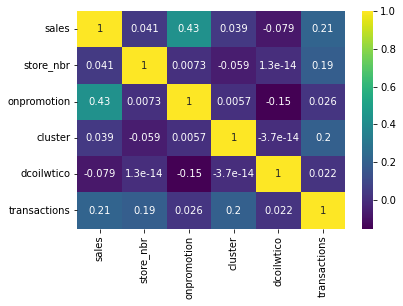

In [24]:
sns.heatmap(train.corr(),annot=True,cmap='viridis')

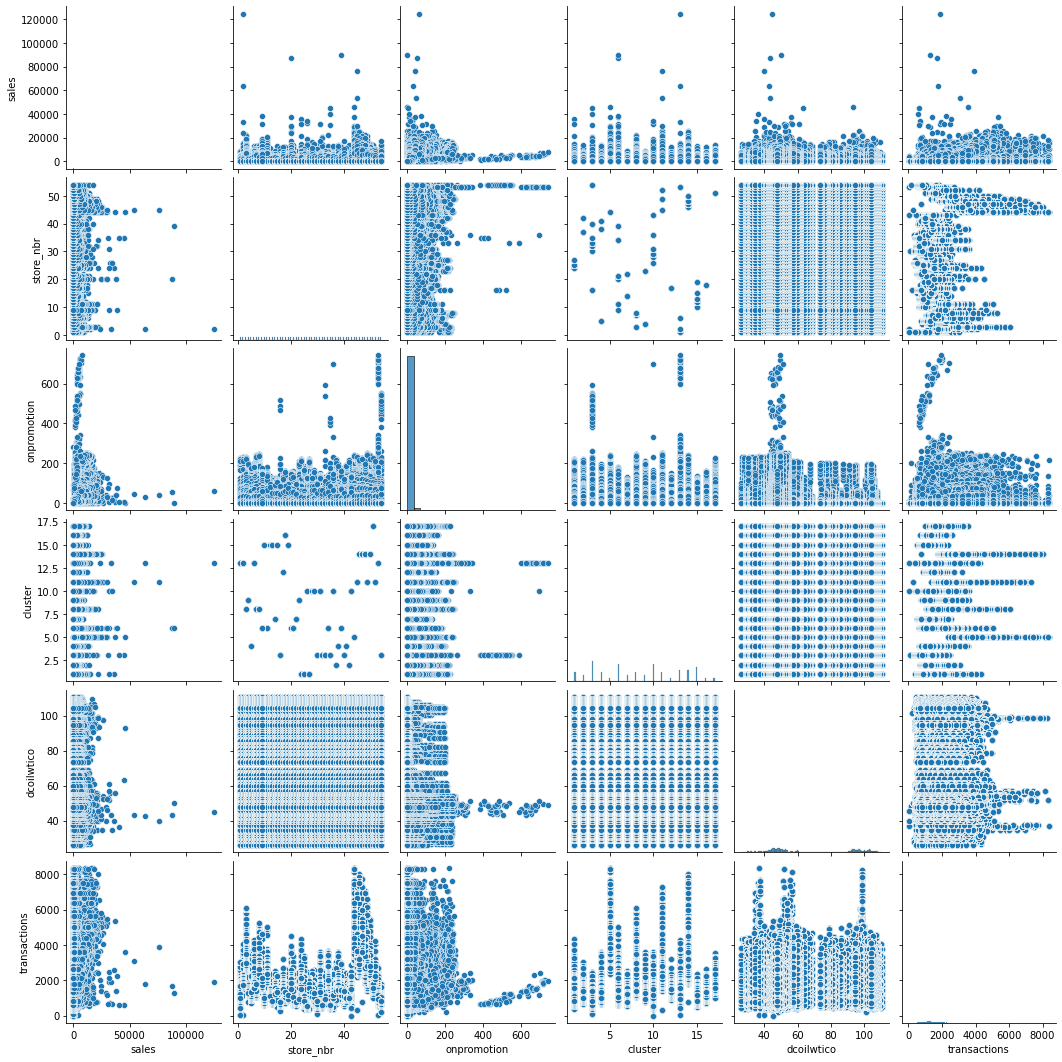

In [62]:
sns.pairplot(train)

__store nbr__

<AxesSubplot:xlabel='store_nbr', ylabel='sales'>

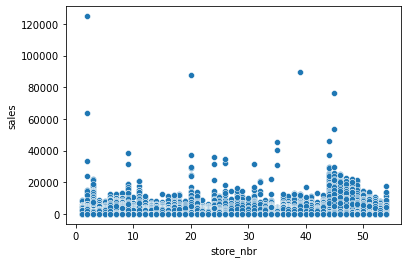

In [99]:
sns.scatterplot(data=train,x='store_nbr',y='sales')

In [102]:
train.groupby(['store_nbr'],as_index=False).sales.agg(['count','median','mean','std','max']).sort_values(by='median',ascending=False)

count  median      mean       std         max
store_nbr                                               
44         55572  75.000 1,117.245 2,685.282  46,271.000
3          55572  64.000   908.405 2,146.185  21,858.000
45         55572  62.000   980.674 2,384.321  76,090.000
47         55572  51.000   916.798 2,222.317  23,024.000
49         55572  48.000   781.330 1,897.862  21,190.000
8          55572  39.000   548.735 1,275.424  13,511.000
46         55572  36.000   753.906 1,889.013  25,238.000
50         55572  32.000   515.602 1,280.878  14,431.000
48         55572  30.000   646.605 1,668.494  22,255.000
6          55572  29.000   453.172 1,072.348  12,878.000
7          55572  27.242   484.993 1,139.705  12,907.000
51         55572  27.000   592.232 1,352.209  14,179.000
2          55572  23.217   387.918 1,079.560 124,717.000
37         55572  23.000   359.365   844.201  11,530.000
38         55572  22.000   339.380   838.488  13,531.000
24         55572  19.000   427.693 1,018.909  35,828.000
1          55572  19.000   254.535   596.827   9,065.000
5          55572  19.000   280.580   652.588   8,216.620
4          55572  19.000   340.274   801.128   8,969.000
9          55572  18.000   475.229 1,269.621  38,422.625
27         55572  18.000   345.282   814.628  14,396.000
41         55572  16.000   269.759   668.116  11,371.000
39         55572  16.000   364.432 1,009.901  89,576.360
11         55572  15.000   509.709 1,360.258  20,891.557
23         55572  13.000   209.663   457.423   6,201.722
34         55572  10.000   307.542   791.592  22,125.000
31         55572  10.000   319.349   834.551  31,851.158
28         55572  10.000   330.799   852.013  16,542.902
17         55572  10.000   324.461   852.435  11,737.000
40         55572   9.000   331.026   925.661  17,114.078
33         55572   9.000   255.138   642.253   9,040.000
25         55572   9.000   205.517   561.161  11,097.000
15         55572   8.000   206.062   542.930  12,669.000
18         55572   8.000   238.598   618.125  12,473.000
19         55572   8.000   234.822   662.227   8,351.000
43         55572   7.000   294.963   814.483  12,143.201
54         55572   6.000   198.976   582.223  17,614.000
14         55572   6.000   204.922   540.669   8,496.000
16         55572   6.000   197.697   529.371  11,377.000
13         55572   6.000   189.359   551.555   8,294.000
12         55572   6.000   191.809   521.523  11,609.557
30         55572   5.000   132.838   347.580  10,392.000
36         55572   5.000   275.722   739.625  12,774.617
26         55572   5.000   139.551   420.371  34,454.000
10         55572   5.000   172.999   477.274  10,801.000
53         55572   3.000   201.831   600.435   8,443.000
35         55572   3.000   138.139   470.106  45,361.000
32         55572   3.000   107.101   334.004  20,602.000
52         55572   0.000    48.517   449.116  10,462.000
29         55572   0.000   175.001   607.751  14,380.789
20         55572   0.000   232.508   966.156  87,438.516
21         55572   0.000   166.550   651.286  13,924.218
22         55572   0.000    73.602   316.225   8,909.000
42         55572   0.000   160.976   583.518  13,494.000

__family__

<AxesSubplot:xlabel='family', ylabel='sales'>

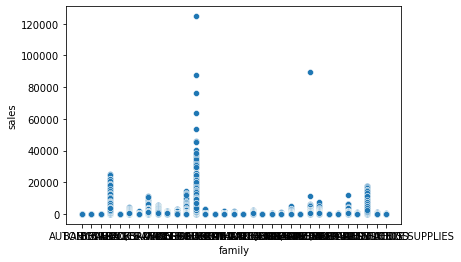

In [103]:
sns.scatterplot(data=train,x='family',y='sales')

In [29]:
train.groupby(['family'],as_index=False).sales.agg(['median','mean','std','max']).sort_values(by='median',ascending=False)

median      mean       std         max
family                                                              
GROCERY I                  3,185.000 3,776.972 2,874.209 124,717.000
BEVERAGES                  1,784.000 2,385.793 2,307.882  25,413.000
CLEANING                     938.000 1,072.417   734.681  11,377.000
DAIRY                        520.000   709.155   671.950   5,636.000
BREAD/BAKERY                 401.000   463.336   368.246   4,551.298
PRODUCE                      398.291 1,349.352 2,186.481  17,850.615
MEATS                        224.937   341.850   455.908  89,576.360
PERSONAL CARE                222.000   270.433   226.512   7,504.000
DELI                         218.971   265.135   210.417   2,118.325
POULTRY                      205.743   350.532   400.512  12,143.201
HOME CARE                    143.000   176.198   209.917   2,504.000
EGGS                         131.000   171.421   161.827   3,110.000
FROZEN FOODS                  83.000   154.767   324.971  14,541.550
PREPARED FOODS                63.960    96.770   104.695     912.568
LIQUOR,WINE,BEER              47.000    85.188   126.556   4,821.000
HOME AND KITCHEN I            12.000    20.470    35.968   1,935.000
GROCERY II                    12.000    21.584    31.062   2,931.000
HOME AND KITCHEN II            9.000    16.722    31.299   1,568.000
SEAFOOD                        8.000    22.163    32.628     274.440
LINGERIE                       5.000     7.182     9.475   1,059.000
AUTOMOTIVE                     5.000     6.101     6.192     255.000
CELEBRATION                    3.000     8.370    15.927   1,783.000
PLAYERS AND ELECTRONICS        2.000     6.187    10.544     269.000
BEAUTY                         2.000     3.716     4.795     136.000
LAWN AND GARDEN                1.000     6.035    12.283     712.000
HARDWARE                       1.000     1.138     1.638      49.000
LADIESWEAR                     0.000     7.161    13.946     147.000
HOME APPLIANCES                0.000     0.457     0.970      15.000
MAGAZINES                      0.000     2.929     6.008      79.000
BABY CARE                      0.000     0.111     0.681     116.000
PET SUPPLIES                   0.000     3.921     7.658     106.000
BOOKS                          0.000     0.071     0.548      51.000
SCHOOL AND OFFICE SUPPLIES     0.000     2.962    21.746   1,332.000

__onpromotion__

In [33]:
train.groupby('onpromotion').sales.agg(['count','median','mean','std','max','min']).sort_values(by='median',ascending=False)

count     median       mean       std        max        min
onpromotion                                                               
249                2 12,377.413 12,377.413   227.083 12,537.985 12,216.841
250                1 12,231.239 12,231.239       NaN 12,231.239 12,231.239
248                1 12,169.133 12,169.133       NaN 12,169.133 12,169.133
247                5 11,770.139  9,297.240 4,996.598 13,780.029  1,266.000
246                1 11,490.971 11,490.971       NaN 11,490.971 11,490.971
...              ...        ...        ...       ...        ...        ...
3              45862    325.391    871.408 1,421.447 45,361.000      0.000
2              79386    245.311    662.926 1,146.456 20,891.557      0.000
1             174551    145.348    467.557   971.816 16,967.000      0.000
0            2389559      3.000    158.247   614.894 89,576.360      0.000
279                1      0.000      0.000       NaN      0.000      0.000

[362 rows x 6 columns]

<AxesSubplot:xlabel='onpromotion', ylabel='sales'>

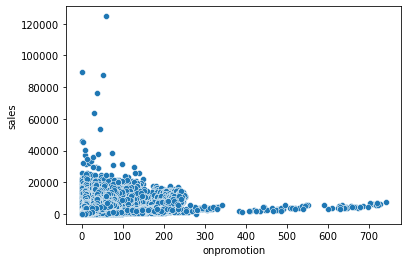

In [34]:
sns.scatterplot(data=train,x='onpromotion',y='sales')

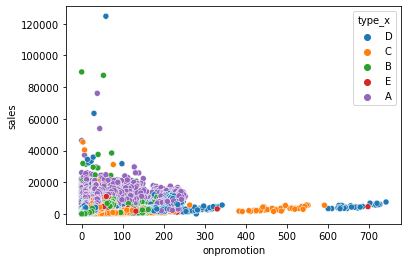

In [36]:
sns.scatterplot(data=train,x='onpromotion',y='sales',hue='type_x');

__city__

In [37]:
train.groupby('city').sales.agg(['count','median','mean','std','max','min']).sort_values(by='median',ascending=False)

count  median    mean       std         max   min
city                                                              
Quito          1000296  24.000 556.577 1,562.695 124,717.000 0.000
Loja             55572  22.000 339.380   838.488  13,531.000 0.000
Ambato          111144  21.000 362.632   973.824  14,431.000 0.000
Daule            55572  18.000 345.282   814.628  14,396.000 0.000
Cayambe          55572  15.000 509.709 1,360.258  20,891.557 0.000
Machala         111144  13.000 300.392   807.803  17,114.078 0.000
Babahoyo         55572  10.000 319.349   834.551  31,851.158 0.000
Quevedo          55572   9.000 255.138   642.253   9,040.000 0.000
Salinas          55572   9.000 205.517   561.161  11,097.000 0.000
Cuenca          166716   8.000 294.924   836.654  89,576.360 0.000
Guaranda         55572   8.000 234.822   662.227   8,351.000 0.000
Ibarra           55572   8.000 206.062   542.930  12,669.000 0.000
Esmeraldas       55572   7.000 294.963   814.483  12,143.201 0.000
Guayaquil       444576   7.000 276.594   806.412  35,828.000 0.000
El Carmen        55572   6.000 198.976   582.223  17,614.000 0.000
Latacunga       111144   6.000 190.584   536.748  11,609.557 0.000
Riobamba         55572   6.000 204.922   540.669   8,496.000 0.000
Libertad         55572   5.000 275.722   739.625  12,774.617 0.000
Santo Domingo   166716   5.000 214.942   615.687  13,924.218 0.000
Playas           55572   3.000 138.139   470.106  45,361.000 0.000
Puyo             55572   0.000  73.602   316.225   8,909.000 0.000
Manta           111144   0.000 125.174   535.712  10,462.000 0.000

__type_x__

In [38]:
train.groupby('type_x').sales.agg(['count','median','mean','std','max','min']).sort_values(by='median',ascending=False)

count  median    mean       std         max   min
type_x                                                     
A        500148  24.000 705.879 1,892.701  76,090.000 0.000
D       1000296  16.000 350.979   965.729 124,717.000 0.000
B        444576   7.000 326.740   977.529  89,576.360 0.000
C        833580   5.000 197.263   581.311  45,361.000 0.000
E        222288   4.000 269.121   761.423  16,542.902 0.000

<AxesSubplot:xlabel='type_x', ylabel='sales'>

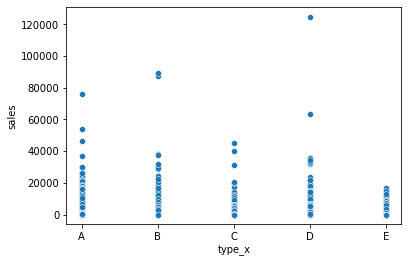

In [57]:
sns.scatterplot(data=train.sort_values('type_x'),x='type_x',y='sales')

__cluster__

In [59]:
train.groupby('cluster').sales.agg(['count','median','mean','std','max','min']).sort_values(by='median',ascending=False)

count  median      mean       std         max   min
cluster                                                      
5         55572  75.000 1,117.245 2,685.282  46,271.000 0.000
8        166716  42.000   647.378 1,595.399  21,858.000 0.000
14       222288  36.000   708.228 1,804.016  25,238.000 0.000
17        55572  27.000   592.232 1,352.209  14,179.000 0.000
4        166716  19.000   296.573   725.282  13,531.000 0.000
9        111144  16.000   274.968   655.578   8,969.000 0.000
1        166716  15.000   326.164   825.005  35,828.000 0.000
13       222288  14.000   324.364   876.440 124,717.000 0.000
12        55572  10.000   324.461   852.435  11,737.000 0.000
16        55572   8.000   238.598   618.125  12,473.000 0.000
6        333432   7.000   342.662 1,045.357  89,576.360 0.000
15       277860   7.000   199.010   554.876  12,669.000 0.000
3        389004   6.000   194.416   582.955  45,361.000 0.000
2        111144   5.000   260.171   732.406  13,494.000 0.000
10       333432   5.000   255.898   731.493  34,454.000 0.000
11       166716   5.000   603.507 1,823.033  76,090.000 0.000
7        111144   0.000   139.262   447.739   8,909.000 0.000

<AxesSubplot:xlabel='cluster', ylabel='sales'>

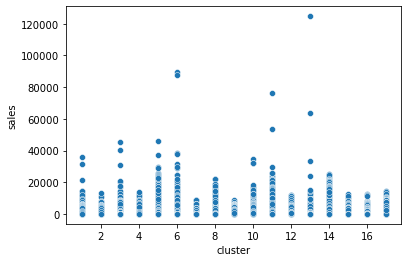

In [60]:
sns.scatterplot(data=train.sort_values('cluster'),x='cluster',y='sales')

__dcoilwtico__

In [64]:
train.dcoilwtico.describe()

count   2,072,466.000
mean           67.926
std            25.666
min            26.190
25%            46.380
50%            53.330
75%            95.800
max           110.620
Name: dcoilwtico, dtype: float64

<AxesSubplot:xlabel='dcoilwtico', ylabel='sales'>

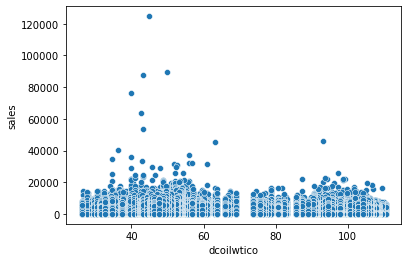

In [67]:
sns.scatterplot(data=train,x='dcoilwtico',y='sales')

__transaction__

In [70]:
train.transactions.describe()

count   2,755,104.000
mean        1,694.602
std           963.281
min             5.000
25%         1,046.000
50%         1,393.000
75%         2,079.000
max         8,359.000
Name: transactions, dtype: float64

__type_y__

In [72]:
train.type_y.unique()

array(['Weekday', 'Weekend', 'Holiday', 'Additional'], dtype=object)

In [74]:
test.isnull().sum()

id                  0
day                 0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
type_x              0
cluster             0
dcoilwtico       7128
transactions    28512
type_y              0
dtype: int64

In [65]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

NameError: name 'KFold' is not defined

In [95]:
train.store_nbr.value_counts()

1     55572
46    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
47    55572
10    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
35    55572
34    55572
33    55572
32    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
9     55572
Name: store_nbr, dtype: int64

In [26]:
train[train.dcoilwtico.isna()]['type_y'].value_counts()

Holiday       3366
Additional     594
Name: type_y, dtype: int64

In [30]:
day = train.loc[train.dcoilwtico.isna(),'date']

In [44]:
pd.to_datetime(day,format='%Y-%m-%d').dt.day_name().value_counts()

Saturday     429462
Sunday       427680
Monday        40986
Friday        14256
Thursday      10692
Tuesday        3564
Wednesday      1782
Name: date, dtype: int64

In [45]:
train.loc[train.dcoilwtico.isna(),['date','type_y']]

date type_y
0        2013-01-01    NaN
1        2013-01-01    NaN
2        2013-01-01    NaN
3        2013-01-01    NaN
4        2013-01-01    NaN
...             ...    ...
2997319  2017-08-13    NaN
2997320  2017-08-13    NaN
2997321  2017-08-13    NaN
2997322  2017-08-13    NaN
2997323  2017-08-13    NaN

[928422 rows x 2 columns]

In [18]:
train.describe()

id     store_nbr         sales   onpromotion       cluster  \
count 3,000,888.000 3,000,888.000 3,000,888.000 3,000,888.000 3,000,888.000   
mean  1,500,443.500        27.500       357.776         2.603         8.481   
std     866,281.892        15.586     1,101.998        12.219         4.650   
min           0.000         1.000         0.000         0.000         1.000   
25%     750,221.750        14.000         0.000         0.000         4.000   
50%   1,500,443.500        27.500        11.000         0.000         8.500   
75%   2,250,665.250        41.000       195.847         0.000        13.000   
max   3,000,887.000        54.000   124,717.000       741.000        17.000   

         dcoilwtico  transactions  
count 2,072,466.000 2,755,104.000  
mean         67.926     1,694.602  
std          25.666       963.281  
min          26.190         5.000  
25%          46.380     1,046.000  
50%          53.330     1,393.000  
75%          95.800     2,079.000  
max         110.620     8,359.000